In [1]:
import tensorflow as tf

2024-04-05 19:16:14.024817: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 19:16:15.280244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(2).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(x, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size=(3, 3), use_bias=False, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return x

def identity_block(x, filters):
    x_identity = x

    x = conv_block(x, filters)
    x = layers.Add()([x, x_identity])
    x = layers.Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), use_bias=False, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)

    x = conv_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)

    x = conv_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)

    x = conv_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "RN_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./RNmodels/'+str(start_epoch-1)+model_name)
else:
    
    input_shape = (30, 30, 168)
    num_classes = 4
    model = resnet18(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-05 19:21:16.347626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14545 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 15, 15, 64)   526848      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 15, 15, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 256)    589824      ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_8 (Activation)      (None, 2, 2, 256)    0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 2, 2, 256)    589824      ['activation_8[0][0]']           
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./RNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-05 19:21:28.286638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


600/600 - 18s - loss: 1.5376 - acc: 0.3575 - val_loss: 2.5797 - val_acc: 0.3406 - 18s/epoch - 30ms/step


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/1RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.348125
Confusion Matrix:
[[ 22   7  10 361]
 [ 44 121  79 156]
 [ 53  47  50 250]
 [ 26   3   7 364]]
Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.06      0.08       400
           1       0.68      0.30      0.42       400
           2       0.34      0.12      0.18       400
           3       0.32      0.91      0.48       400

    accuracy                           0.35      1600
   macro avg       0.37      0.35      0.29      1600
weighted avg       0.37      0.35      0.29      1600


Epoch:  2
600/600 - 14s - loss: 1.2178 - acc: 0.4675 - val_loss: 1.2360 - val_acc: 0.4556 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/2RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.47375
Confusion Matrix:
[[151  16 104 129]
 [ 25 141 211  23]
 [ 38  94 222  46]
 [ 58   7  91 244]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45       400
           1       0.55      0.35      0.43       400
           2       0.35      0.56      0.43       400
           3       0.55      0.61      0.58       400

    accuracy                           0.47      1600
   macro avg       0.50      0.47      0.47      1600
weighted avg       0.50      0.47      0.47      1600


Epoch:  3
600/600 - 13s - loss: 0.8967 - acc: 0.6288 - val_loss: 0.9104 - val_acc: 0.6012 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/3RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.603125
Confusion Matrix:
[[235  32 128   5]
 [ 35 218 143   4]
 [ 58 131 210   1]
 [ 45   6  47 302]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.56      0.55      0.55       400
           2       0.40      0.53      0.45       400
           3       0.97      0.76      0.85       400

    accuracy                           0.60      1600
   macro avg       0.64      0.60      0.62      1600
weighted avg       0.64      0.60      0.62      1600


Epoch:  4
600/600 - 13s - loss: 0.6271 - acc: 0.7421 - val_loss: 0.8660 - val_acc: 0.6344 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/4RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.616875
Confusion Matrix:
[[310  23  63   4]
 [ 81 193 122   4]
 [109 111 177   3]
 [ 72   3  18 307]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.78      0.64       400
           1       0.58      0.48      0.53       400
           2       0.47      0.44      0.45       400
           3       0.97      0.77      0.86       400

    accuracy                           0.62      1600
   macro avg       0.64      0.62      0.62      1600
weighted avg       0.64      0.62      0.62      1600


Epoch:  5
600/600 - 13s - loss: 0.4411 - acc: 0.8292 - val_loss: 1.3564 - val_acc: 0.5188 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/5RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.500625
Confusion Matrix:
[[246  44 110   0]
 [ 35 228 137   0]
 [ 49 118 233   0]
 [191  41  74  94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.61      0.53       400
           1       0.53      0.57      0.55       400
           2       0.42      0.58      0.49       400
           3       1.00      0.23      0.38       400

    accuracy                           0.50      1600
   macro avg       0.61      0.50      0.49      1600
weighted avg       0.61      0.50      0.49      1600


Epoch:  6
600/600 - 14s - loss: 0.3374 - acc: 0.8752 - val_loss: 0.8829 - val_acc: 0.6819 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/6RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.643125
Confusion Matrix:
[[196  96  99   9]
 [ 17 327  49   7]
 [ 30 225 142   3]
 [ 13  14   9 364]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.49      0.60       400
           1       0.49      0.82      0.62       400
           2       0.47      0.35      0.41       400
           3       0.95      0.91      0.93       400

    accuracy                           0.64      1600
   macro avg       0.67      0.64      0.64      1600
weighted avg       0.67      0.64      0.64      1600


Epoch:  7
600/600 - 13s - loss: 0.2960 - acc: 0.8867 - val_loss: 0.8112 - val_acc: 0.7113 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/7RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.683125
Confusion Matrix:
[[196 103  77  24]
 [ 11 328  49  12]
 [ 17 191 179  13]
 [  7   2   1 390]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.49      0.62       400
           1       0.53      0.82      0.64       400
           2       0.58      0.45      0.51       400
           3       0.89      0.97      0.93       400

    accuracy                           0.68      1600
   macro avg       0.71      0.68      0.67      1600
weighted avg       0.71      0.68      0.67      1600


Epoch:  8
600/600 - 13s - loss: 0.1981 - acc: 0.9271 - val_loss: 1.1794 - val_acc: 0.6594 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/8RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.68375
Confusion Matrix:
[[356  36   8   0]
 [ 93 300   6   1]
 [151 171  76   2]
 [ 29   9   0 362]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.89      0.69       400
           1       0.58      0.75      0.66       400
           2       0.84      0.19      0.31       400
           3       0.99      0.91      0.95       400

    accuracy                           0.68      1600
   macro avg       0.75      0.68      0.65      1600
weighted avg       0.75      0.68      0.65      1600


Epoch:  9
600/600 - 14s - loss: 0.1738 - acc: 0.9396 - val_loss: 0.7837 - val_acc: 0.7544 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/9RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.6925
Confusion Matrix:
[[173 102 125   0]
 [  4 351  45   0]
 [  9 162 228   1]
 [ 11  19  14 356]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.43      0.58       400
           1       0.55      0.88      0.68       400
           2       0.55      0.57      0.56       400
           3       1.00      0.89      0.94       400

    accuracy                           0.69      1600
   macro avg       0.75      0.69      0.69      1600
weighted avg       0.75      0.69      0.69      1600


Epoch:  10
600/600 - 14s - loss: 0.1598 - acc: 0.9421 - val_loss: 1.2800 - val_acc: 0.6712 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/10RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.66625
Confusion Matrix:
[[371  20   5   4]
 [119 277   4   0]
 [182 146  72   0]
 [ 42  10   2 346]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.93      0.67       400
           1       0.61      0.69      0.65       400
           2       0.87      0.18      0.30       400
           3       0.99      0.86      0.92       400

    accuracy                           0.67      1600
   macro avg       0.75      0.67      0.63      1600
weighted avg       0.75      0.67      0.63      1600


Epoch:  11
600/600 - 13s - loss: 0.1309 - acc: 0.9538 - val_loss: 0.8485 - val_acc: 0.7475 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/11RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.748125
Confusion Matrix:
[[327  61  12   0]
 [ 57 332  11   0]
 [ 95 130 175   0]
 [ 12  11  14 363]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.73       400
           1       0.62      0.83      0.71       400
           2       0.83      0.44      0.57       400
           3       1.00      0.91      0.95       400

    accuracy                           0.75      1600
   macro avg       0.78      0.75      0.74      1600
weighted avg       0.78      0.75      0.74      1600


Epoch:  12
600/600 - 14s - loss: 0.1064 - acc: 0.9646 - val_loss: 0.7980 - val_acc: 0.7894 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/12RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.778125
Confusion Matrix:
[[323  46  27   4]
 [ 62 324  13   1]
 [112  77 204   7]
 [  6   0   0 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.72       400
           1       0.72      0.81      0.77       400
           2       0.84      0.51      0.63       400
           3       0.97      0.98      0.98       400

    accuracy                           0.78      1600
   macro avg       0.79      0.78      0.77      1600
weighted avg       0.79      0.78      0.77      1600


Epoch:  13
600/600 - 13s - loss: 0.0883 - acc: 0.9694 - val_loss: 1.1578 - val_acc: 0.7013 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/13RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.69
Confusion Matrix:
[[257 130  13   0]
 [ 12 385   3   0]
 [ 55 201 144   0]
 [ 35  42   5 318]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       400
           1       0.51      0.96      0.66       400
           2       0.87      0.36      0.51       400
           3       1.00      0.80      0.89       400

    accuracy                           0.69      1600
   macro avg       0.77      0.69      0.68      1600
weighted avg       0.77      0.69      0.68      1600


Epoch:  14
600/600 - 14s - loss: 0.1099 - acc: 0.9654 - val_loss: 1.3691 - val_acc: 0.6531 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/14RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.63
Confusion Matrix:
[[280  17   7  96]
 [ 79 230   5  86]
 [ 76  61  98 165]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       400
           1       0.75      0.57      0.65       400
           2       0.89      0.24      0.38       400
           3       0.54      1.00      0.70       400

    accuracy                           0.63      1600
   macro avg       0.70      0.63      0.60      1600
weighted avg       0.70      0.63      0.60      1600


Epoch:  15
600/600 - 14s - loss: 0.1015 - acc: 0.9656 - val_loss: 0.9195 - val_acc: 0.7437 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/15RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.744375
Confusion Matrix:
[[219  57  52  72]
 [ 29 311  23  37]
 [ 12  55 261  72]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.55      0.66       400
           1       0.74      0.78      0.76       400
           2       0.78      0.65      0.71       400
           3       0.69      1.00      0.82       400

    accuracy                           0.74      1600
   macro avg       0.76      0.74      0.74      1600
weighted avg       0.76      0.74      0.74      1600


Epoch:  16
600/600 - 14s - loss: 0.0935 - acc: 0.9677 - val_loss: 0.9106 - val_acc: 0.7556 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/16RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.730625
Confusion Matrix:
[[128  60 165  47]
 [ 12 319  66   3]
 [  5  68 322   5]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.32      0.47       400
           1       0.71      0.80      0.75       400
           2       0.58      0.81      0.68       400
           3       0.88      1.00      0.94       400

    accuracy                           0.73      1600
   macro avg       0.76      0.73      0.71      1600
weighted avg       0.76      0.73      0.71      1600


Epoch:  17
600/600 - 14s - loss: 0.0736 - acc: 0.9775 - val_loss: 0.6763 - val_acc: 0.8244 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/17RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.80875
Confusion Matrix:
[[312  71  17   0]
 [ 52 341   7   0]
 [ 50 105 244   1]
 [  2   0   1 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       400
           1       0.66      0.85      0.74       400
           2       0.91      0.61      0.73       400
           3       1.00      0.99      0.99       400

    accuracy                           0.81      1600
   macro avg       0.83      0.81      0.81      1600
weighted avg       0.83      0.81      0.81      1600


Epoch:  18
600/600 - 14s - loss: 0.0759 - acc: 0.9742 - val_loss: 0.7631 - val_acc: 0.8106 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/18RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.745
Confusion Matrix:
[[230  82  87   1]
 [ 30 359  10   1]
 [  9 148 243   0]
 [ 18   6  16 360]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.60      0.90      0.72       400
           2       0.68      0.61      0.64       400
           3       0.99      0.90      0.94       400

    accuracy                           0.74      1600
   macro avg       0.77      0.74      0.74      1600
weighted avg       0.77      0.74      0.74      1600


Epoch:  19
600/600 - 14s - loss: 0.0738 - acc: 0.9760 - val_loss: 0.7298 - val_acc: 0.8069 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/19RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.74
Confusion Matrix:
[[183 160  57   0]
 [  6 386   8   0]
 [  9 132 259   0]
 [ 26  12   6 356]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.46      0.59       400
           1       0.56      0.96      0.71       400
           2       0.78      0.65      0.71       400
           3       1.00      0.89      0.94       400

    accuracy                           0.74      1600
   macro avg       0.79      0.74      0.74      1600
weighted avg       0.79      0.74      0.74      1600


Epoch:  20
600/600 - 14s - loss: 0.0470 - acc: 0.9825 - val_loss: 1.1058 - val_acc: 0.7700 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/20RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.73625
Confusion Matrix:
[[143  58 199   0]
 [  4 317  79   0]
 [  1  27 372   0]
 [  5   6  43 346]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.36      0.52       400
           1       0.78      0.79      0.78       400
           2       0.54      0.93      0.68       400
           3       1.00      0.86      0.93       400

    accuracy                           0.74      1600
   macro avg       0.81      0.74      0.73      1600
weighted avg       0.81      0.74      0.73      1600


Epoch:  21
600/600 - 13s - loss: 0.1069 - acc: 0.9627 - val_loss: 0.6630 - val_acc: 0.8194 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/21RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.825
Confusion Matrix:
[[315  58  27   0]
 [ 48 349   3   0]
 [ 46  96 257   1]
 [  0   1   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       400
           1       0.69      0.87      0.77       400
           2       0.90      0.64      0.75       400
           3       1.00      1.00      1.00       400

    accuracy                           0.82      1600
   macro avg       0.84      0.83      0.82      1600
weighted avg       0.84      0.82      0.82      1600


Epoch:  22
600/600 - 14s - loss: 0.0452 - acc: 0.9852 - val_loss: 0.7235 - val_acc: 0.8031 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/22RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.794375
Confusion Matrix:
[[269  50  53  28]
 [ 41 319  16  24]
 [ 29  44 283  44]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73       400
           1       0.77      0.80      0.78       400
           2       0.80      0.71      0.75       400
           3       0.81      1.00      0.89       400

    accuracy                           0.79      1600
   macro avg       0.79      0.79      0.79      1600
weighted avg       0.79      0.79      0.79      1600


Epoch:  23
600/600 - 14s - loss: 0.0396 - acc: 0.9852 - val_loss: 3.5755 - val_acc: 0.4694 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/23RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.444375
Confusion Matrix:
[[113 287   0   0]
 [  1 399   0   0]
 [  8 355  37   0]
 [ 44 187   7 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.28      0.40       400
           1       0.32      1.00      0.49       400
           2       0.84      0.09      0.17       400
           3       1.00      0.41      0.58       400

    accuracy                           0.44      1600
   macro avg       0.71      0.44      0.41      1600
weighted avg       0.71      0.44      0.41      1600


Epoch:  24
600/600 - 14s - loss: 0.0664 - acc: 0.9790 - val_loss: 1.0352 - val_acc: 0.7525 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/24RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.73125
Confusion Matrix:
[[213  10 157  20]
 [ 22 192 140  46]
 [ 14   6 365  15]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.66       400
           1       0.92      0.48      0.63       400
           2       0.55      0.91      0.69       400
           3       0.83      1.00      0.91       400

    accuracy                           0.73      1600
   macro avg       0.79      0.73      0.72      1600
weighted avg       0.79      0.73      0.72      1600


Epoch:  25
600/600 - 14s - loss: 0.0337 - acc: 0.9881 - val_loss: 0.7752 - val_acc: 0.7987 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/25RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.784375
Confusion Matrix:
[[218  42 104  36]
 [ 22 315  55   8]
 [ 14  41 323  22]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.55      0.67       400
           1       0.79      0.79      0.79       400
           2       0.67      0.81      0.73       400
           3       0.86      1.00      0.92       400

    accuracy                           0.78      1600
   macro avg       0.79      0.78      0.78      1600
weighted avg       0.79      0.78      0.78      1600


Epoch:  26
600/600 - 13s - loss: 0.0617 - acc: 0.9783 - val_loss: 0.8452 - val_acc: 0.7675 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/26RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.759375
Confusion Matrix:
[[184 117  38  61]
 [ 10 361  16  13]
 [ 28  84 270  18]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.46      0.59       400
           1       0.64      0.90      0.75       400
           2       0.83      0.68      0.75       400
           3       0.81      1.00      0.90       400

    accuracy                           0.76      1600
   macro avg       0.78      0.76      0.75      1600
weighted avg       0.78      0.76      0.75      1600


Epoch:  27
600/600 - 14s - loss: 0.0687 - acc: 0.9765 - val_loss: 0.8147 - val_acc: 0.7806 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/27RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.791875
Confusion Matrix:
[[286  37  36  41]
 [ 38 322  27  13]
 [ 21  43 259  77]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77       400
           1       0.80      0.81      0.80       400
           2       0.80      0.65      0.72       400
           3       0.75      1.00      0.86       400

    accuracy                           0.79      1600
   macro avg       0.80      0.79      0.79      1600
weighted avg       0.80      0.79      0.79      1600


Epoch:  28
600/600 - 14s - loss: 0.0413 - acc: 0.9840 - val_loss: 0.8436 - val_acc: 0.7681 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/28RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.76125
Confusion Matrix:
[[254  68  25  53]
 [ 29 355   5  11]
 [ 45  77 209  69]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.64      0.70       400
           1       0.71      0.89      0.79       400
           2       0.87      0.52      0.65       400
           3       0.75      1.00      0.86       400

    accuracy                           0.76      1600
   macro avg       0.78      0.76      0.75      1600
weighted avg       0.78      0.76      0.75      1600


Epoch:  29
600/600 - 13s - loss: 0.0342 - acc: 0.9892 - val_loss: 0.5227 - val_acc: 0.8644 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/29RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.82875
Confusion Matrix:
[[275  73  50   2]
 [ 22 361  17   0]
 [ 27  81 291   1]
 [  0   1   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.69      0.76       400
           1       0.70      0.90      0.79       400
           2       0.81      0.73      0.77       400
           3       0.99      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.84      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600


Epoch:  30
600/600 - 14s - loss: 0.0586 - acc: 0.9812 - val_loss: 0.6787 - val_acc: 0.8081 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/30RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 1s 11ms/step
Accuracy: 0.796875
Confusion Matrix:
[[224  79  59  38]
 [ 13 360  20   7]
 [ 10  67 291  32]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.56      0.69       400
           1       0.71      0.90      0.79       400
           2       0.79      0.73      0.76       400
           3       0.84      1.00      0.91       400

    accuracy                           0.80      1600
   macro avg       0.81      0.80      0.79      1600
weighted avg       0.81      0.80      0.79      1600


Epoch:  31
600/600 - 14s - loss: 0.0282 - acc: 0.9908 - val_loss: 0.4745 - val_acc: 0.8763 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/31RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.843125
Confusion Matrix:
[[247  48 104   1]
 [ 23 330  47   0]
 [ 11  17 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       400
           1       0.84      0.82      0.83       400
           2       0.71      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  32
600/600 - 13s - loss: 0.0081 - acc: 0.9983 - val_loss: 0.6429 - val_acc: 0.8600 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/32RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.8225
Confusion Matrix:
[[223  43 133   1]
 [ 22 317  61   0]
 [  9  15 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.56      0.68       400
           1       0.85      0.79      0.82       400
           2       0.66      0.94      0.78       400
           3       1.00      1.00      1.00       400

    accuracy                           0.82      1600
   macro avg       0.85      0.82      0.82      1600
weighted avg       0.85      0.82      0.82      1600


Epoch:  33
600/600 - 14s - loss: 0.0032 - acc: 0.9994 - val_loss: 0.5222 - val_acc: 0.8763 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/33RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.84625
Confusion Matrix:
[[255  56  89   0]
 [ 24 345  31   0]
 [ 11  35 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       400
           1       0.79      0.86      0.83       400
           2       0.75      0.89      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.85      0.85      0.84      1600
weighted avg       0.85      0.85      0.84      1600


Epoch:  34
600/600 - 13s - loss: 0.1085 - acc: 0.9638 - val_loss: 0.7963 - val_acc: 0.7638 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/34RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.75
Confusion Matrix:
[[225  86  24  65]
 [ 10 371   6  13]
 [ 19 104 204  73]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       400
           1       0.66      0.93      0.77       400
           2       0.87      0.51      0.64       400
           3       0.73      1.00      0.84       400

    accuracy                           0.75      1600
   macro avg       0.79      0.75      0.74      1600
weighted avg       0.79      0.75      0.74      1600


Epoch:  35
600/600 - 13s - loss: 0.0248 - acc: 0.9927 - val_loss: 1.4874 - val_acc: 0.6825 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/35RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.696875
Confusion Matrix:
[[ 51  65  40 244]
 [  2 356  25  17]
 [  4  37 308  51]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.13      0.22       400
           1       0.78      0.89      0.83       400
           2       0.83      0.77      0.80       400
           3       0.56      1.00      0.72       400

    accuracy                           0.70      1600
   macro avg       0.76      0.70      0.64      1600
weighted avg       0.76      0.70      0.64      1600


Epoch:  36
600/600 - 14s - loss: 0.0168 - acc: 0.9958 - val_loss: 0.6408 - val_acc: 0.8369 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/36RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.82875
Confusion Matrix:
[[265  30  85  20]
 [ 41 329  27   3]
 [ 17  42 332   9]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       400
           1       0.82      0.82      0.82       400
           2       0.75      0.83      0.79       400
           3       0.93      1.00      0.96       400

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.83      0.83      0.83      1600


Epoch:  37
600/600 - 14s - loss: 0.0637 - acc: 0.9787 - val_loss: 0.9939 - val_acc: 0.7894 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/37RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.7625
Confusion Matrix:
[[296  78  11  15]
 [ 43 350   2   5]
 [ 77 113 174  36]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       400
           1       0.65      0.88      0.74       400
           2       0.93      0.43      0.59       400
           3       0.88      1.00      0.93       400

    accuracy                           0.76      1600
   macro avg       0.79      0.76      0.75      1600
weighted avg       0.79      0.76      0.75      1600


Epoch:  38
600/600 - 14s - loss: 0.0337 - acc: 0.9904 - val_loss: 0.4691 - val_acc: 0.8725 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/38RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.84375
Confusion Matrix:
[[254  37 109   0]
 [ 19 347  34   0]
 [ 10  38 352   0]
 [  3   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74       400
           1       0.82      0.87      0.84       400
           2       0.71      0.88      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  39
600/600 - 14s - loss: 0.0100 - acc: 0.9971 - val_loss: 0.6780 - val_acc: 0.8163 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/39RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.795
Confusion Matrix:
[[295  19  86   0]
 [ 40 330  30   0]
 [ 19  25 356   0]
 [ 52   2  55 291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       400
           1       0.88      0.82      0.85       400
           2       0.68      0.89      0.77       400
           3       1.00      0.73      0.84       400

    accuracy                           0.80      1600
   macro avg       0.82      0.80      0.80      1600
weighted avg       0.82      0.80      0.80      1600


Epoch:  40
600/600 - 13s - loss: 0.0047 - acc: 0.9992 - val_loss: 0.4767 - val_acc: 0.8825 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/40RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.858125
Confusion Matrix:
[[271  46  82   1]
 [ 21 360  19   0]
 [ 13  45 342   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       400
           1       0.80      0.90      0.85       400
           2       0.77      0.85      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600


Epoch:  41
600/600 - 14s - loss: 4.8172e-04 - acc: 1.0000 - val_loss: 0.4758 - val_acc: 0.8925 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/41RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.8575
Confusion Matrix:
[[255  57  88   0]
 [ 13 368  19   0]
 [ 11  40 349   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.79      0.92      0.85       400
           2       0.77      0.87      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  42
600/600 - 14s - loss: 1.9495e-04 - acc: 1.0000 - val_loss: 0.4821 - val_acc: 0.8938 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/42RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.859375
Confusion Matrix:
[[255  56  89   0]
 [ 14 368  18   0]
 [ 10  38 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  43
600/600 - 14s - loss: 1.3614e-04 - acc: 1.0000 - val_loss: 0.4905 - val_acc: 0.8950 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/43RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.859375
Confusion Matrix:
[[254  56  90   0]
 [ 14 368  18   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  44
600/600 - 13s - loss: 1.0098e-04 - acc: 1.0000 - val_loss: 0.5001 - val_acc: 0.8950 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/44RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86
Confusion Matrix:
[[254  56  90   0]
 [ 14 369  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.86       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  45
600/600 - 13s - loss: 7.6168e-05 - acc: 1.0000 - val_loss: 0.5104 - val_acc: 0.8956 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/45RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86
Confusion Matrix:
[[254  56  90   0]
 [ 14 369  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.86       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  46
600/600 - 14s - loss: 5.7870e-05 - acc: 1.0000 - val_loss: 0.5214 - val_acc: 0.8956 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/46RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.859375
Confusion Matrix:
[[254  57  89   0]
 [ 14 369  17   0]
 [ 10  38 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  47
600/600 - 14s - loss: 4.4050e-05 - acc: 1.0000 - val_loss: 0.5329 - val_acc: 0.8975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/47RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86
Confusion Matrix:
[[254  57  89   0]
 [ 14 369  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.86       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  48
600/600 - 13s - loss: 3.3549e-05 - acc: 1.0000 - val_loss: 0.5450 - val_acc: 0.8975 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/48RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86
Confusion Matrix:
[[254  57  89   0]
 [ 14 369  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       400
           1       0.80      0.92      0.86       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  49
600/600 - 13s - loss: 2.5535e-05 - acc: 1.0000 - val_loss: 0.5576 - val_acc: 0.8969 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/49RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.859375
Confusion Matrix:
[[253  58  89   0]
 [ 14 369  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.63      0.75       400
           1       0.80      0.92      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  50
600/600 - 14s - loss: 1.9409e-05 - acc: 1.0000 - val_loss: 0.5706 - val_acc: 0.8969 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/50RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.859375
Confusion Matrix:
[[252  59  89   0]
 [ 13 370  17   0]
 [ 10  37 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       400
           1       0.79      0.93      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  51
600/600 - 14s - loss: 1.4728e-05 - acc: 1.0000 - val_loss: 0.5842 - val_acc: 0.8963 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/51RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.86
Confusion Matrix:
[[252  58  90   0]
 [ 13 370  17   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       400
           1       0.80      0.93      0.86       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  52
600/600 - 14s - loss: 1.1160e-05 - acc: 1.0000 - val_loss: 0.5982 - val_acc: 0.8956 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/52RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.86
Confusion Matrix:
[[250  60  90   0]
 [ 13 371  16   0]
 [ 10  35 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       400
           1       0.80      0.93      0.86       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  53
600/600 - 13s - loss: 8.4509e-06 - acc: 1.0000 - val_loss: 0.6126 - val_acc: 0.8963 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/53RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.86
Confusion Matrix:
[[250  61  89   0]
 [ 13 371  16   0]
 [ 10  35 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       400
           1       0.79      0.93      0.86       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  54
600/600 - 14s - loss: 6.3891e-06 - acc: 1.0000 - val_loss: 0.6272 - val_acc: 0.8969 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/54RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.859375
Confusion Matrix:
[[250  62  88   0]
 [ 13 371  16   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       400
           1       0.79      0.93      0.85       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  55
600/600 - 14s - loss: 4.8223e-06 - acc: 1.0000 - val_loss: 0.6420 - val_acc: 0.8969 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/55RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.85875
Confusion Matrix:
[[249  64  87   0]
 [ 13 370  17   0]
 [ 10  35 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       400
           1       0.79      0.93      0.85       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  56
600/600 - 14s - loss: 3.6319e-06 - acc: 1.0000 - val_loss: 0.6572 - val_acc: 0.8969 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/56RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.858125
Confusion Matrix:
[[248  65  87   0]
 [ 13 370  17   0]
 [ 10  35 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       400
           1       0.79      0.93      0.85       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  57
600/600 - 14s - loss: 2.7322e-06 - acc: 1.0000 - val_loss: 0.6725 - val_acc: 0.8981 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/57RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.85625
Confusion Matrix:
[[246  66  88   0]
 [ 13 369  18   0]
 [ 10  35 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.74       400
           1       0.79      0.92      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  58
600/600 - 13s - loss: 2.0516e-06 - acc: 1.0000 - val_loss: 0.6882 - val_acc: 0.8981 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/58RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855625
Confusion Matrix:
[[246  66  88   0]
 [ 13 369  18   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.74       400
           1       0.78      0.92      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  59
600/600 - 13s - loss: 1.5367e-06 - acc: 1.0000 - val_loss: 0.7040 - val_acc: 0.8988 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/59RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855625
Confusion Matrix:
[[246  67  87   0]
 [ 13 369  18   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.74       400
           1       0.78      0.92      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  60
600/600 - 14s - loss: 1.1510e-06 - acc: 1.0000 - val_loss: 0.7202 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/60RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.855625
Confusion Matrix:
[[246  67  87   0]
 [ 13 369  18   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.74       400
           1       0.78      0.92      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  61
600/600 - 14s - loss: 8.5905e-07 - acc: 1.0000 - val_loss: 0.7358 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/61RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.85625
Confusion Matrix:
[[247  67  86   0]
 [ 13 369  18   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.62      0.74       400
           1       0.78      0.92      0.85       400
           2       0.77      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  62
600/600 - 14s - loss: 6.4246e-07 - acc: 1.0000 - val_loss: 0.7533 - val_acc: 0.8975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/62RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.855
Confusion Matrix:
[[245  67  87   1]
 [ 13 369  18   0]
 [ 10  36 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       400
           1       0.78      0.92      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  63
600/600 - 13s - loss: 4.8386e-07 - acc: 1.0000 - val_loss: 0.7673 - val_acc: 0.8981 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/63RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.854375
Confusion Matrix:
[[244  68  87   1]
 [ 12 371  17   0]
 [ 10  38 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.78      0.93      0.85       400
           2       0.77      0.88      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  64
600/600 - 14s - loss: 3.9376e-07 - acc: 1.0000 - val_loss: 0.7909 - val_acc: 0.8963 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/64RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.855625
Confusion Matrix:
[[244  66  89   1]
 [ 11 371  18   0]
 [  9  37 354   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.78      0.93      0.85       400
           2       0.77      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  65
600/600 - 14s - loss: 0.2470 - acc: 0.9348 - val_loss: 0.8543 - val_acc: 0.7500 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/65RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.754375
Confusion Matrix:
[[164   4 215  17]
 [ 18 251 131   0]
 [  1   5 392   2]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.41      0.56       400
           1       0.97      0.63      0.76       400
           2       0.53      0.98      0.69       400
           3       0.95      1.00      0.98       400

    accuracy                           0.75      1600
   macro avg       0.84      0.75      0.75      1600
weighted avg       0.84      0.75      0.75      1600


Epoch:  66
600/600 - 14s - loss: 0.0583 - acc: 0.9819 - val_loss: 0.4409 - val_acc: 0.8719 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/66RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.87625
Confusion Matrix:
[[304  23  73   0]
 [ 33 343  24   0]
 [ 19  25 356   0]
 [  0   1   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       400
           1       0.88      0.86      0.87       400
           2       0.79      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.88      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.88      0.88      0.88      1600


Epoch:  67
600/600 - 13s - loss: 0.0096 - acc: 0.9975 - val_loss: 0.4130 - val_acc: 0.8950 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/67RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.854375
Confusion Matrix:
[[255  42 103   0]
 [ 19 360  21   0]
 [ 12  36 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74       400
           1       0.82      0.90      0.86       400
           2       0.74      0.88      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.86      0.85      0.85      1600
weighted avg       0.86      0.85      0.85      1600


Epoch:  68
600/600 - 13s - loss: 0.0056 - acc: 0.9983 - val_loss: 0.4875 - val_acc: 0.8831 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/68RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.84375
Confusion Matrix:
[[246  37 117   0]
 [ 13 350  37   0]
 [ 13  32 355   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73       400
           1       0.84      0.88      0.85       400
           2       0.70      0.89      0.78       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  69
600/600 - 14s - loss: 0.0303 - acc: 0.9900 - val_loss: 0.6042 - val_acc: 0.8637 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/69RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.810625
Confusion Matrix:
[[192 117  91   0]
 [ 13 378   9   0]
 [ 11  60 329   0]
 [  1   1   0 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62       400
           1       0.68      0.94      0.79       400
           2       0.77      0.82      0.79       400
           3       1.00      0.99      1.00       400

    accuracy                           0.81      1600
   macro avg       0.83      0.81      0.80      1600
weighted avg       0.83      0.81      0.80      1600


Epoch:  70
600/600 - 14s - loss: 0.0432 - acc: 0.9871 - val_loss: 0.7983 - val_acc: 0.8025 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/70RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.7875
Confusion Matrix:
[[158  20 203  19]
 [ 10 327  61   2]
 [  2  16 375   7]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.40      0.55       400
           1       0.90      0.82      0.86       400
           2       0.59      0.94      0.72       400
           3       0.93      1.00      0.97       400

    accuracy                           0.79      1600
   macro avg       0.84      0.79      0.77      1600
weighted avg       0.84      0.79      0.77      1600


Epoch:  71
600/600 - 14s - loss: 0.0081 - acc: 0.9985 - val_loss: 0.4342 - val_acc: 0.8906 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/71RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.83375
Confusion Matrix:
[[220  93  86   1]
 [  8 378  14   0]
 [ 13  51 336   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       400
           1       0.72      0.94      0.82       400
           2       0.77      0.84      0.80       400
           3       1.00      1.00      1.00       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.83      1600
weighted avg       0.85      0.83      0.83      1600


Epoch:  72
600/600 - 14s - loss: 0.0054 - acc: 0.9985 - val_loss: 0.9048 - val_acc: 0.7656 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/72RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.76625
Confusion Matrix:
[[213   9  80  98]
 [ 37 281  43  39]
 [  8   6 332  54]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65       400
           1       0.95      0.70      0.81       400
           2       0.73      0.83      0.78       400
           3       0.68      1.00      0.81       400

    accuracy                           0.77      1600
   macro avg       0.80      0.77      0.76      1600
weighted avg       0.80      0.77      0.76      1600


Epoch:  73
600/600 - 13s - loss: 0.0918 - acc: 0.9702 - val_loss: 0.8575 - val_acc: 0.8006 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/73RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.7475
Confusion Matrix:
[[ 95 183  83  39]
 [  0 381  17   2]
 [  2  48 320  30]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.24      0.38       400
           1       0.62      0.95      0.75       400
           2       0.76      0.80      0.78       400
           3       0.85      1.00      0.92       400

    accuracy                           0.75      1600
   macro avg       0.80      0.75      0.71      1600
weighted avg       0.80      0.75      0.71      1600


Epoch:  74
600/600 - 14s - loss: 0.0241 - acc: 0.9927 - val_loss: 0.4620 - val_acc: 0.8788 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/74RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.864375
Confusion Matrix:
[[266  73  60   1]
 [  7 382  11   0]
 [ 21  43 336   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.67      0.77       400
           1       0.77      0.95      0.85       400
           2       0.83      0.84      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  75
600/600 - 14s - loss: 0.0092 - acc: 0.9973 - val_loss: 0.4544 - val_acc: 0.8938 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/75RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.869375
Confusion Matrix:
[[272  28 100   0]
 [ 16 355  29   0]
 [ 14  21 365   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       400
           1       0.88      0.89      0.88       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600


Epoch:  76
600/600 - 14s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.4414 - val_acc: 0.8944 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/76RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.868125
Confusion Matrix:
[[273  41  86   0]
 [ 14 362  24   0]
 [ 14  31 355   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       400
           1       0.83      0.91      0.87       400
           2       0.76      0.89      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600


Epoch:  77
600/600 - 14s - loss: 2.6888e-04 - acc: 1.0000 - val_loss: 0.4495 - val_acc: 0.8975 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/77RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86625
Confusion Matrix:
[[268  51  81   0]
 [ 12 365  23   0]
 [ 15  30 355   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       400
           1       0.82      0.91      0.86       400
           2       0.77      0.89      0.83       400
           3       1.00      0.99      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  78
600/600 - 13s - loss: 1.8097e-04 - acc: 1.0000 - val_loss: 0.4605 - val_acc: 0.9000 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/78RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.865
Confusion Matrix:
[[265  50  85   0]
 [ 12 366  22   0]
 [ 15  30 355   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.82      0.92      0.87       400
           2       0.77      0.89      0.82       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  79
600/600 - 13s - loss: 1.3147e-04 - acc: 1.0000 - val_loss: 0.4721 - val_acc: 0.8994 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/79RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.864375
Confusion Matrix:
[[263  52  85   0]
 [ 11 367  22   0]
 [ 15  30 355   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76       400
           1       0.82      0.92      0.86       400
           2       0.77      0.89      0.82       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  80
600/600 - 13s - loss: 9.7763e-05 - acc: 1.0000 - val_loss: 0.4839 - val_acc: 0.8981 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/80RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.864375
Confusion Matrix:
[[260  55  85   0]
 [ 10 369  21   0]
 [ 14  30 356   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       400
           1       0.81      0.92      0.86       400
           2       0.77      0.89      0.83       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  81
600/600 - 14s - loss: 7.3404e-05 - acc: 1.0000 - val_loss: 0.4962 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/81RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86625
Confusion Matrix:
[[261  55  84   0]
 [  9 371  20   0]
 [ 14  30 356   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.81      0.93      0.87       400
           2       0.77      0.89      0.83       400
           3       1.00      0.99      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  82
600/600 - 14s - loss: 5.5396e-05 - acc: 1.0000 - val_loss: 0.5089 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/82RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.866875
Confusion Matrix:
[[262  55  83   0]
 [  9 371  20   0]
 [ 14  30 356   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.76       400
           1       0.81      0.93      0.87       400
           2       0.77      0.89      0.83       400
           3       1.00      0.99      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  83
600/600 - 14s - loss: 4.1877e-05 - acc: 1.0000 - val_loss: 0.5220 - val_acc: 0.9000 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/83RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 1s 14ms/step
Accuracy: 0.865625
Confusion Matrix:
[[260  57  83   0]
 [ 10 371  19   0]
 [ 14  30 356   0]
 [  1   0   1 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      0.99      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  84
600/600 - 14s - loss: 3.1656e-05 - acc: 1.0000 - val_loss: 0.5355 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/84RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.86625
Confusion Matrix:
[[260  58  82   0]
 [ 10 371  19   0]
 [ 14  30 356   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  85
600/600 - 14s - loss: 2.3912e-05 - acc: 1.0000 - val_loss: 0.5492 - val_acc: 0.9000 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/85RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.866875
Confusion Matrix:
[[261  58  81   0]
 [ 10 371  19   0]
 [ 14  30 356   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  86
600/600 - 14s - loss: 1.8055e-05 - acc: 1.0000 - val_loss: 0.5633 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/86RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.868125
Confusion Matrix:
[[262  58  80   0]
 [ 10 371  19   0]
 [ 14  30 356   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.87      1600
weighted avg       0.88      0.87      0.87      1600


Epoch:  87
600/600 - 14s - loss: 1.3630e-05 - acc: 1.0000 - val_loss: 0.5778 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/87RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.8675
Confusion Matrix:
[[262  58  80   0]
 [ 10 371  19   0]
 [ 14  31 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  88
600/600 - 14s - loss: 1.0272e-05 - acc: 1.0000 - val_loss: 0.5926 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/88RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.866875
Confusion Matrix:
[[261  58  81   0]
 [ 10 371  19   0]
 [ 14  31 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  89
600/600 - 14s - loss: 7.7288e-06 - acc: 1.0000 - val_loss: 0.6077 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/89RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.866875
Confusion Matrix:
[[261  58  81   0]
 [ 10 371  19   0]
 [ 14  31 355   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.81      0.93      0.86       400
           2       0.78      0.89      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  90
600/600 - 14s - loss: 5.8038e-06 - acc: 1.0000 - val_loss: 0.6229 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/90RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.865
Confusion Matrix:
[[260  59  81   0]
 [ 10 371  19   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.80      0.93      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  91
600/600 - 14s - loss: 4.3545e-06 - acc: 1.0000 - val_loss: 0.6383 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/91RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.865625
Confusion Matrix:
[[260  59  81   0]
 [ 10 372  18   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.80      0.93      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  92
600/600 - 14s - loss: 3.2682e-06 - acc: 1.0000 - val_loss: 0.6538 - val_acc: 0.9013 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/92RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.865
Confusion Matrix:
[[259  60  81   0]
 [ 10 372  18   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.80      0.93      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  93
600/600 - 14s - loss: 2.4494e-06 - acc: 1.0000 - val_loss: 0.6697 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/93RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.864375
Confusion Matrix:
[[257  61  82   0]
 [  9 373  18   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.93      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  94
600/600 - 14s - loss: 1.8343e-06 - acc: 1.0000 - val_loss: 0.6857 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/94RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.864375
Confusion Matrix:
[[256  61  83   0]
 [  9 374  17   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  95
600/600 - 14s - loss: 1.3721e-06 - acc: 1.0000 - val_loss: 0.7018 - val_acc: 0.9006 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/95RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.865
Confusion Matrix:
[[257  61  82   0]
 [  9 374  17   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  96
600/600 - 14s - loss: 1.0233e-06 - acc: 1.0000 - val_loss: 0.7182 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/96RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.865625
Confusion Matrix:
[[257  61  82   0]
 [  8 375  17   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  97
600/600 - 14s - loss: 7.6301e-07 - acc: 1.0000 - val_loss: 0.7345 - val_acc: 0.8994 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/97RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.865625
Confusion Matrix:
[[257  61  82   0]
 [  8 375  17   0]
 [ 14  33 353   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  98
600/600 - 14s - loss: 5.6781e-07 - acc: 1.0000 - val_loss: 0.7511 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/98RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.865625
Confusion Matrix:
[[258  61  81   0]
 [  8 375  17   0]
 [ 14  34 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  99
600/600 - 13s - loss: 4.2329e-07 - acc: 1.0000 - val_loss: 0.7674 - val_acc: 0.8988 - 13s/epoch - 22ms/step


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/99RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 1s 12ms/step
Accuracy: 0.86625
Confusion Matrix:
[[258  61  81   0]
 [  8 376  16   0]
 [ 14  34 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  100
600/600 - 14s - loss: 3.1513e-07 - acc: 1.0000 - val_loss: 0.7845 - val_acc: 0.8988 - 14s/epoch - 23ms/step


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./RNmodels/100RN__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 1s 13ms/step
Accuracy: 0.865625
Confusion Matrix:
[[257  62  81   0]
 [  8 376  16   0]
 [ 14  34 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600

Testing time (s) = 2986.8532210988924



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 1s 12ms/step
Accuracy: 0.865625
Confusion Matrix:
[[257  62  81   0]
 [  8 376  16   0]
 [ 14  34 352   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.64      0.76       400
           1       0.80      0.94      0.86       400
           2       0.78      0.88      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600



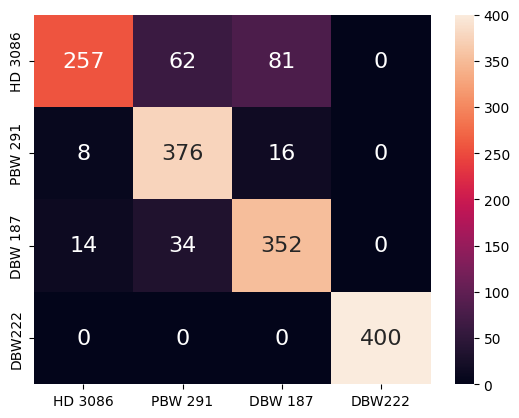

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()